In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import copy
import random

In [11]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
data_dir = '/kaggle/input/trashnet/dataset-resized'

In [12]:
# Data augmentation (stronger)
transform_train = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(10, translate=(0.05, 0.05)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomResizedCrop(128, scale=(0.75, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [13]:
# Load dataset
full_dataset = datasets.ImageFolder(data_dir, transform=transform_train)
class_names = full_dataset.classes

In [14]:
# Split dataset into train, val, test
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

val_data.dataset.transform = transform_test
test_data.dataset.transform = transform_test

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [15]:
# Improved deeper CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, len(class_names))
        )

    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = CNN().to(device)

In [16]:
# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=4, factor=0.5, verbose=True)

In [17]:
# Train the model
num_epochs = 50
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_acc = 0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(100 * correct / total)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_acc = 100 * correct / total
    val_accs.append(val_acc)

    scheduler.step(val_loss / len(val_loader))

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}%, Val Acc: {val_acc:.2f}%")


Epoch [1/50], Train Loss: 1.3069, Val Loss: 1.1546, Train Acc: 49.89%, Val Acc: 54.62%
Epoch [2/50], Train Loss: 1.1544, Val Loss: 1.1727, Train Acc: 56.00%, Val Acc: 59.37%
Epoch [3/50], Train Loss: 1.0493, Val Loss: 1.3860, Train Acc: 62.39%, Val Acc: 47.76%
Epoch [4/50], Train Loss: 1.0350, Val Loss: 0.9922, Train Acc: 61.14%, Val Acc: 64.12%
Epoch [5/50], Train Loss: 0.9112, Val Loss: 0.9927, Train Acc: 67.25%, Val Acc: 60.69%
Epoch [6/50], Train Loss: 0.8957, Val Loss: 0.8672, Train Acc: 68.10%, Val Acc: 72.03%
Epoch [7/50], Train Loss: 0.8646, Val Loss: 0.8191, Train Acc: 68.10%, Val Acc: 69.13%
Epoch [8/50], Train Loss: 0.7981, Val Loss: 0.9552, Train Acc: 71.89%, Val Acc: 64.38%
Epoch [9/50], Train Loss: 0.8146, Val Loss: 0.8364, Train Acc: 71.04%, Val Acc: 71.77%
Epoch [10/50], Train Loss: 0.7632, Val Loss: 0.8907, Train Acc: 72.68%, Val Acc: 67.55%
Epoch [11/50], Train Loss: 0.7415, Val Loss: 0.7566, Train Acc: 73.93%, Val Acc: 69.92%
Epoch [12/50], Train Loss: 0.6763, Val Lo

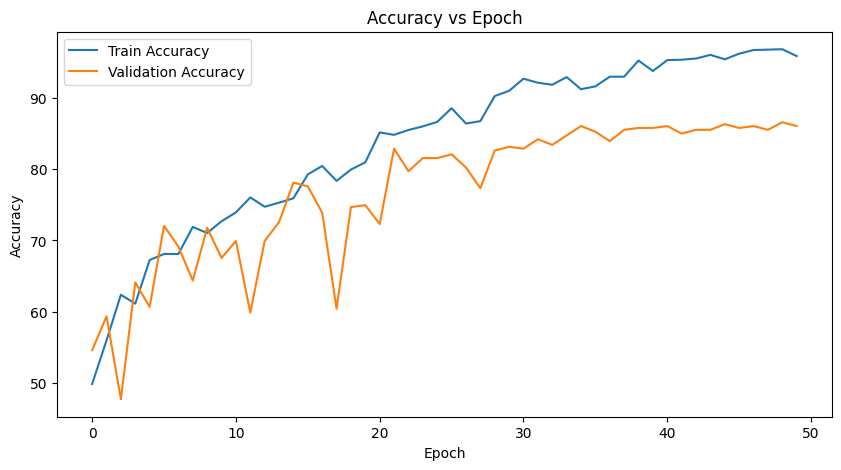

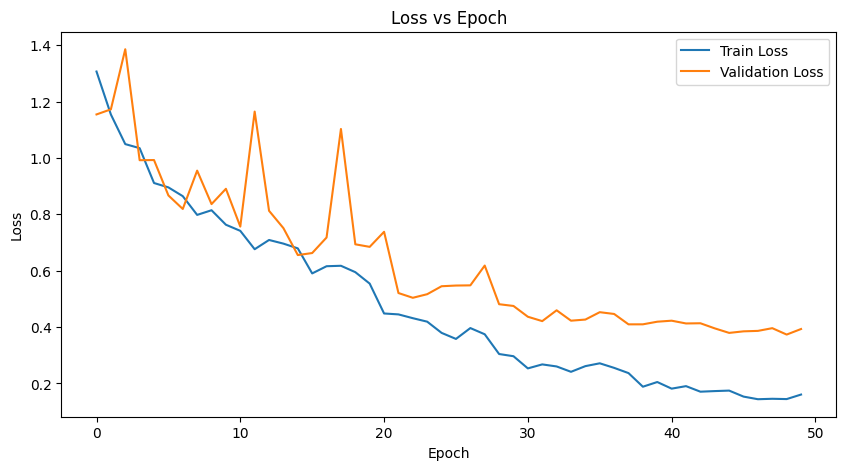

In [18]:
# Load best model weights
model.load_state_dict(best_model_wts)

# Plot accuracy
plt.figure(figsize=(10,5))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epoch')
plt.show()

# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epoch')
plt.show()

In [19]:
# Testing the model
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 86.84%


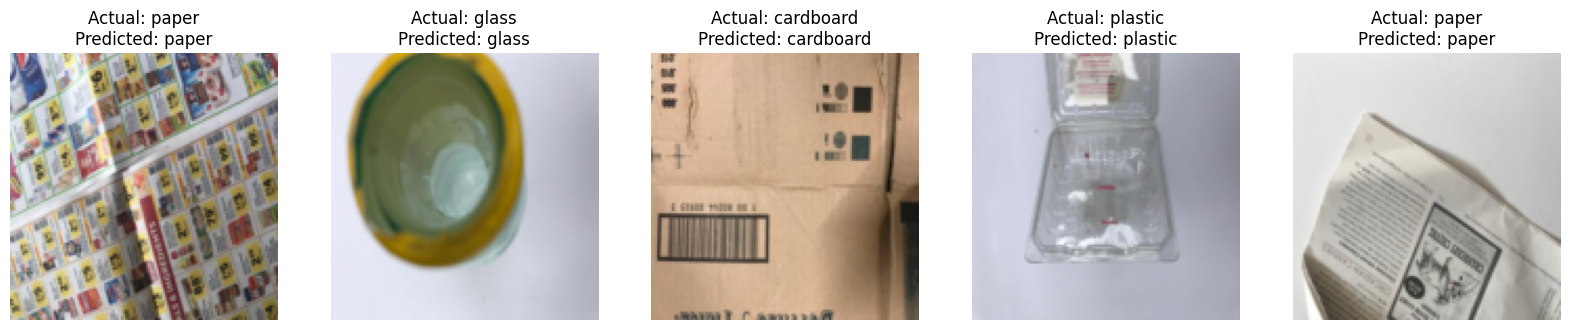

In [20]:
# Show 10 test samples with predictions
samples = list(test_data)
random.shuffle(samples)
samples = samples[:5]

plt.figure(figsize=(20, 10))
for i, (image, label) in enumerate(samples):
    img_tensor = image.unsqueeze(0).to(device)
    output = model(img_tensor)
    _, pred = torch.max(output.data, 1)
    pred_label = class_names[pred.item()]
    actual_label = class_names[label]

    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image * 0.5) + 0.5
    
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(f"Actual: {actual_label}\nPredicted: {pred_label}")
    plt.axis('off')
plt.show()